In [1]:
import pickle
from sql_scripts import create_connection, encode_array_for_sql
from sql_scripts import decode_array_from_sql, train_val_load

import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import keras

# # from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold, ShuffleSplit

# custom functions
from speech_dependencies import save_model_to_disk, graph_spectrogram, load_waves
from model_dependencies import new_keras, plot_results
plt.rcParams['figure.dpi'] = 80

## Creating a Directory for the Files

In [2]:
folder_names = [f for f in os.listdir('train/audio') if not 'background' in f]
folder_names.sort()

file = open("train/testing_list.txt", "r")
testing_list = file.read().split('\n')
file.close()
file = open("train/validation_list.txt", "r")
validation_list = file.read().split('\n')

master_file_list = []
master_target_list = []
train_val_test_list = []
for phrase in folder_names:
    file_list = [phrase + '/' + f for f in os.listdir('train/audio/' + phrase) if '.wav' in f]
    for file in file_list:
        if file in testing_list:
            train_val_test_list.append('test')
        elif file in validation_list:
            train_val_test_list.append('val')
        else:
            train_val_test_list.append('train')
        master_target_list.append(phrase)
        master_file_list.append(file)
data = np.transpose(np.array([master_file_list, master_target_list, train_val_test_list]))
master_df = pd.DataFrame(data = data, columns=['filename','target','train_val_test'])
master_df.head()

,filename,target,train_val_test
0,bed/00176480_nohash_0.wav,bed,train
1,bed/004ae714_nohash_0.wav,bed,train
2,bed/004ae714_nohash_1.wav,bed,train
3,bed/00f0204f_nohash_0.wav,bed,train
4,bed/00f0204f_nohash_1.wav,bed,train


In [3]:
num_classes = len(master_df['target'].unique().tolist())
# SKF is just being used to batch the data into memory, not do any sort of k-fold training process

X_master = master_df['filename'][[(val in ['train','val']) for val in master_df['train_val_test']]]
y_master = master_df['target'][[(val in ['train','val']) for val in master_df['train_val_test']]]
X_master, y_master = np.array(X_master), np.array(y_master)

y_master_set = list(set(y_master))
mapping = {}
for y in range(len(y_master_set)):
    mapping[y_master_set[y]] = y
print(f'Label mapping:\n{mapping}')

Label mapping:
{'sheila': 0, 'no': 1, 'six': 2, 'bed': 3, 'off': 4, 'house': 5, 'up': 6, 'five': 7, 'wow': 8, 'go': 9, 'stop': 10, 'one': 11, 'nine': 12, 'two': 13, 'yes': 14, 'tree': 15, 'on': 16, 'down': 17, 'happy': 18, 'four': 19, 'seven': 20, 'cat': 21, 'right': 22, 'eight': 23, 'marvin': 24, 'zero': 25, 'bird': 26, 'dog': 27, 'three': 28, 'left': 29}


## Converting the wav files to spectrograms and storing in a SQLite DB with info

In [4]:
conn = create_connection("spectrograms.db")

2.6.0


working on batch: 1/150
loading training set
	bad redgram shape


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7558: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


	x shape (before reshape):(288, 14, 20)
	x shape (after reshape):(288, 14, 20, 1)
	y shape:(288, 30)


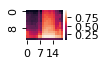

loading validation set
	x shape (before reshape):(97, 14, 20)
	x shape (after reshape):(97, 14, 20, 1)
	y shape:(97, 30)


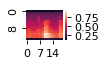

working on batch: 2/150
loading training set
	x shape (before reshape):(289, 14, 20)
	x shape (after reshape):(289, 14, 20, 1)
	y shape:(289, 30)


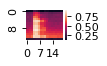

loading validation set
	x shape (before reshape):(97, 14, 20)
	x shape (after reshape):(97, 14, 20, 1)
	y shape:(97, 30)


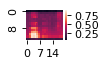

working on batch: 3/150
loading training set


KeyboardInterrupt: 

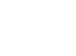

In [5]:
batch_count = 1 # using a counter since enumerate doesn't work on skf.split
total_splits = 150
skf = StratifiedKFold(n_splits=total_splits, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X_master, y_master):
#     if batch_count < 125:
#         print(f'currently looking at batch {batch_count}, already trained up to batch 125. skipping...', end='\r')
#         batch_count += 1
#         continue
    print(f'working on batch: {batch_count}/{total_splits}')
    rs = ShuffleSplit(n_splits=1, test_size=.25, random_state=42)
    X, y = X_master[test_index], y_master[test_index]
    for train_index2, test_index2 in rs.split(X):
        X_train, X_val = X[train_index2], X[test_index2]
        y_train, y_val = y[train_index2], y[test_index2]
        # Split is done, X=filename, y=target
        X_train, y_train = train_val_load(X_train, y_train, mapping, num_classes, train_or_val = 'train')
        X_val, y_val = train_val_load(X_val, y_val, mapping, num_classes, train_or_val = 'val')
        
        ttv = []
        x_sizes = []
        y_sizes = []
        
        X_train, y_train = list(X_train), list(y_train)
        for i, image in enumerate(X_train):
            ttv.append('train')
            x_sizes.append(image.shape[1])
            y_sizes.append(image.shape[0])
            X_train[i] = encode_array_for_sql(image)
            y_train[i] = encode_array_for_sql(y_train[i])
            
        X_val, y_val = list(X_val), list(y_val)
        for i, image in enumerate(X_val):
            ttv.append('val')
            x_sizes.append(image.shape[1])
            y_sizes.append(image.shape[0])
            X_val[i] = encode_array_for_sql(image)
            y_val[i] = encode_array_for_sql(y_val[i])
            
        temp_df = pd.DataFrame({'t_t_v':ttv,'words':y_train+y_val,'x_size':x_sizes,'y_size':y_sizes,'images':X_train+X_val})
#         temp_df.to_sql('specgrams', conn, if_exists='replace', index=False)
        temp_df.to_sql('specgrams', conn, if_exists='append', index=False)
        
        X_train, y_train, X_val, y_val = [],[],[],[]
    batch_count += 1